In [76]:
# Methods to be used repeatedly
def Verify(expression: bool, message: str):
    if not expression:
        raise Exception(message)
    else:
        return
    
def report_missing_features(X):
    report = X.isna().sum(axis=1) 
    report = report[report > 0]
    print("Entry index | Number of missing features")
    print(report)



In [77]:
from ucimlrepo import fetch_ucirepo
import pandas as pd
import numpy as np


### step 1 is to obtain the data and remove rows with missing features, we will store these in two objects of type dataset
class dataset:
    def __init__(self, features : np.ndarray, targets : np.ndarray, var_info : np.ndarray):
        self.features = features
        self.targets = targets
        self.var_info = var_info

def regenerate_datasets(print_things = False):
    """
    Returns: ageDataset, breastDataset
    """
    # fetch dataset for age predictions
    national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset = fetch_ucirepo(id=887) 

    X = national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.data.features
    missing_values = X.isna().sum().sum()
    if (missing_values>1):
        if print_things:
            print("Report of missing features for age prediction:")
            report_missing_features(X)
    if print_things:
        print("Number of missing values in the age prediction dataset: " + str(missing_values))
    nan_indices = X[X.isna().any(axis=1)].index
    X = X.dropna().to_numpy()

    y = national_health_and_nutrition_health_survey_2013_2014_nhanes_age_prediction_subset.data.targets
    y = y.drop(index=nan_indices)
    y = y.to_numpy()
    if not np.all((y == "Adult") | (y == "Senior")):
        raise ValueError("Array contains an entry that is not 'Adult' or 'Senior'")
    y = np.where(y == "Senior", 1, 0)

    Verify(len(X) == len(y), "Features and targets are different lengths.")
    var_info = np.array(["Respondent Gender", "Activity", "BMI", "Blood Glucose", "Diabetic", "Oral", "Blood Insulin"])
    ageDataset = dataset(X, y, var_info)

    # fetch dataset for breast cancer detection
    breast_cancer_wisconsin_original = fetch_ucirepo(id=15)  

    X = breast_cancer_wisconsin_original.data.features
    missing_values = X.isna().sum().sum()
    if (missing_values>1):
        if print_things:
            print("Report of missing features for breast cancer detection:")
            report_missing_features(X)
    if print_things:
        print("Number of missing values in the breast cancer prediction dataset: " + str(missing_values))
    nan_indices = X[X.isna().any(axis=1)].index
    X = X.dropna().to_numpy()

    y = breast_cancer_wisconsin_original.data.targets
    y = y.drop(index=nan_indices)
    y = y.to_numpy()
    if not np.all((y == 4) | (y == 2)):
        raise ValueError("Array contains an entry that is not 4 or 2")
    y = np.where(y == 4, 1, 0)


    Verify(len(X) == len(y), "Features and targets are different lengths.")
    var_info = np.array(["Clump Thickness", "Uniformity of Cell Size", "Uniformity of Cell Shape", "Marginal Adhesion", "Single Epithelial Cell Size", "Bare Nuclei", "Bland Chromatin", "Normal Nucleoli", "Mitoses"])
    breastDataset = dataset(X,y,var_info)

    print("\n\n Datasets cleaned.")

    return ageDataset, breastDataset

ageDataset, breastDataset = regenerate_datasets()





 Datasets cleaned.


In [78]:
### Step 2 is to find the means in the positive and negative set for each features
### We'll do this by going back to pandas
import matplotlib.pyplot as plt

# first for the age dataset
targets = ageDataset.targets.squeeze()
x = ageDataset.features.copy()
positive_x = x[targets == 1]
negative_x = x[targets == 0]
means_positive = np.mean(positive_x, axis=0)
means_negative = np.mean(negative_x, axis=0)
squared_difference = np.power(means_positive-means_negative, 2)

# tabling
mean_values_df = pd.DataFrame({
    'Mean Positive': means_positive,
    'Mean Negative': means_negative,
    'Squared Difference': squared_difference
}, index=ageDataset.var_info)
print(mean_values_df)


#second for the breast dataset
targets = breastDataset.targets.squeeze()
x = breastDataset.features.copy()
positive_x = x[targets == 1]
negative_x = x[targets == 0]
means_positive = np.mean(positive_x, axis=0)
means_negative = np.mean(negative_x, axis=0)
squared_difference = np.power(means_positive-means_negative, 2)

# tabling
mean_values_df = pd.DataFrame({
    'Mean Positive': means_positive,
    'Mean Negative': means_negative,
    'Squared Difference': squared_difference
}, index=breastDataset.var_info)
print(mean_values_df)

                   Mean Positive  Mean Negative  Squared Difference
Respondent Gender       1.508242       1.512017            0.000014
Activity                1.909341       1.806165            0.010645
BMI                    27.886264      27.968286            0.006728
Blood Glucose         104.329670      98.644723           32.318625
Diabetic                2.027473       2.014107            0.000179
Oral                  141.208791     109.990596          974.575736
Blood Insulin          10.405247      12.106661            2.894810
                             Mean Positive  Mean Negative  Squared Difference
Clump Thickness                   7.188285       2.963964           17.844884
Uniformity of Cell Size           6.577406       1.306306           27.784490
Uniformity of Cell Shape          6.560669       1.414414           26.483941
Marginal Adhesion                 5.585774       1.346847           17.968504
Single Epithelial Cell Size       5.326360       2.108108         

In [79]:
### Step 3 is the implementation of the KNN model
class KNN:
    def __init__(self, distanceFunctor, k=1, weighted=True, normalize=True):
        self.f = distanceFunctor
        self.k = k
        self.weighted = True
        self.normalize = True

    def fit(self, features : np.ndarray, targets : np.ndarray):
        if self.normalize:
            self.mins = np.min(features, axis = 0)
            self.maxs = np.max(features, axis = 0)
            self.features = (features - self.mins)/(self.maxs-self.mins)
        else:
            self.features = features
        self.targets = targets
    
    #Returns a single lable -> Only works for binary classification (0,1).
    #The returned value is the probability of the true label being 1
    def predict(self, input:np.ndarray):
        #We create a new vector where each value is the distance between the input and each feature vector
        Verify(input.size == self.features.shape[1], "Improper size of input vector during inferencing.")
        normalizedInput = input.__deepcopy__
        if self.normalize:
            normalizedInput = (input - self.mins)/(self.maxs-self.mins)
        distances = self.f(normalizedInput, self.features) #one entry per row in the features matrix
        smallestIndices = np.argpartition(distances, self.k)[:self.k]

        #We can now access the K nearest labels and compute the probabilities
        outputLabelUnclamped = 0.0
        sumOfWeights = 0.0
        for index in smallestIndices:
            currentWeight = 1
            if self.weighted:
                epsilon = 1e-10
                distance = self.f(self.features[index], normalizedInput) + epsilon #avoid division by 0
                currentWeight = 1/distance #Weighted by current distance
            sumOfWeights+=currentWeight
            outputLabelUnclamped += self.targets[index]
        outputLabelUnclamped/=sumOfWeights
        return outputLabelUnclamped

                
#Our functor for computing similarity
class EuclideanDistance:
    def __call__(self, input_vector : np.ndarray, feature_matrix : np.ndarray):
        return np.sqrt(np.sum((feature_matrix - input_vector)**2, axis=1)) #vectorized
    

def evaluate_acc(trueLabels, predictedLabels):
    correctPredictions = np.sum(trueLabels == predictedLabels)
    accuracy = correctPredictions/len(trueLabels)
    return accuracy

def SplitTrainTest(x:np.ndarray, y:np.ndarray, splitRatio = 0.8):
    np.random.seed(420)
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)

    x_shuffled = x[indices]
    y_shuffled = y[indices]
    train_size = int(x.shape[0] * splitRatio)

    x_train = x_shuffled[:train_size]
    y_train = y_shuffled[:train_size]
    x_test = x_shuffled[train_size:]
    y_test = y_shuffled[train_size:]
    return x_train, y_train, x_test, y_test


def TestKNN(dataset, printDebug=False, threshold = 0.5, testOnTrain = False):
    # A quick test to see if the KNN works
    x = dataset.features
    y = dataset.targets
    if not testOnTrain:
        x_train, y_train, x_test, y_test = SplitTrainTest(x, y)
    else:
        x_train = x
        y_train = y
        x_test = x
        y_test = y

    ks = [i for i in range(1,11)]
    accuracies = []
    for k in ks:
        model = KNN(EuclideanDistance(), k=k)
        model.fit(x_train, y_train)
        # Initialize an empty list to store predicted probabilities
        y_pred_prob = []
        # Iterate over each instance in x_test
        for instance in x_test:
            # The model's predict method expects a 1D numpy array
            prob = model.predict(instance.reshape(1, -1))
            y_pred_prob.append(prob)
        y_pred_prob = np.array(y_pred_prob)
        # Threshold the probabilities to get binary predictions
        y_pred = np.where(y_pred_prob > threshold, 1, 0)
        accuracy = evaluate_acc(y_test, y_pred)
        accuracies.append(accuracy)
        if printDebug:
            print(f"KNN accuracy for k = {k}: {accuracy*100:.2f}%")
    indexOfMax = np.argmax(accuracies)
    return (accuracies[indexOfMax], ks[indexOfMax])

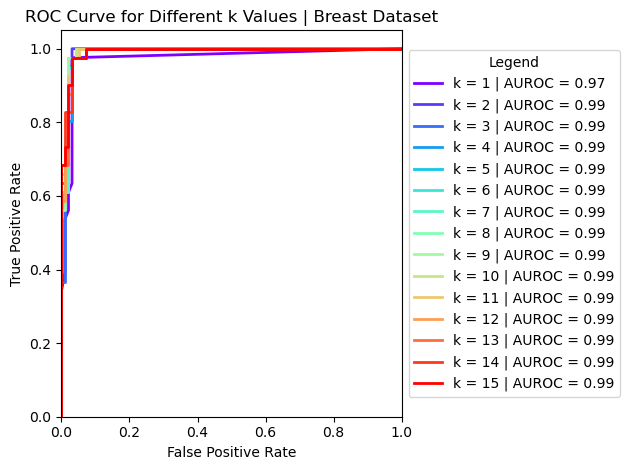

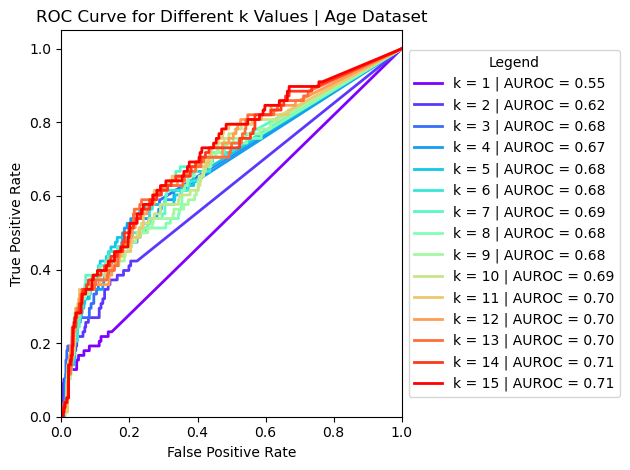

In [80]:
#Task 3: Running experiments

#1. Compare the accuracy and AUROC of KNN and DT algorithm on the two datasets
import sklearn.metrics
import matplotlib.pyplot as plt
import matplotlib.cm as cm

#1.1 AUROC
def create_roc_curve(model, dataset :dataset, testOnTrain = False):
    # A quick test to see if the KNN works
    x = dataset.features
    y = dataset.targets
    if not testOnTrain:
        x_train, y_train, x_test, y_test = SplitTrainTest(x, y)
    else:
        x_train = x
        y_train = y
        x_test = x
        y_test = y
    model.fit(x_train, y_train)
    y_pred_prob = []
    for instance in x_test:
        prob = model.predict(instance.reshape(1, -1))
        y_pred_prob.append(prob)
    y_pred_prob = np.array(y_pred_prob)
    fpr, tpr, thresholds =sklearn.metrics.roc_curve(y_test, y_pred_prob)
    auroc = sklearn.metrics.roc_auc_score(y_test, y_pred_prob)
    return fpr, tpr, auroc

def plot_knn_roc_for_select_ks(dataset, datasetName, krange = 15):
    colors = cm.rainbow(np.linspace(0, 1, krange))
    plt.figure()
    for k, color in zip(range(1, krange+1), colors):
        model = KNN(EuclideanDistance(), k)
        fpr, tpr, auroc = create_roc_curve(model, dataset)
        plt.plot(fpr, tpr, color=color, lw=2, label=f"k = {k} | AUROC = {auroc:.2f}")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Different k Values | {datasetName}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')
    plt.tight_layout()
    plt.show()

plot_knn_roc_for_select_ks(breastDataset, datasetName="Breast Dataset")
plot_knn_roc_for_select_ks(ageDataset, datasetName= "Age Dataset")


In [81]:
#1.2 Accuracy of KNN on both datasets
printDebug = False ##change to false to hide the accuracy for each k
breastAccuracyKNN, k = TestKNN(dataset=breastDataset, printDebug=printDebug)
print(f"Best accuracy KNN breast dataset: {breastAccuracyKNN*100:.2f}%" + "\n\n\n\n")
ageAccuracyKNN, k = TestKNN(dataset=ageDataset, printDebug = printDebug)
print(f"Best accuracy KNN age dataset: {ageAccuracyKNN*100:.2f}%" + "\n\n\n\n")

#2 Test different K values to see how it affects training data accuracy and test data accuracy of the KNN
accuracy, k = TestKNN(dataset=breastDataset, printDebug = True) #First this is accuracy on the test dataset with a train/test split
print(f"Best accuracy for KNN breast dataset on test data at k = {k}: {accuracy*100:.2f}%" + "\n\n\n\n\n")
accuracy, k =TestKNN(dataset=ageDataset, printDebug=True)
print(f"Best accuracy for KNN age dataset on test data at k = {k}: {accuracy*100:.2f}%" + "\n\n\n\n\n")
accuracy, k =TestKNN(dataset=breastDataset, printDebug=True, testOnTrain=True) #Now this is accuracy on the train dataset
print(f"Best accuracy for KNN breast dataset on train data at k = {k}: {accuracy*100:.2f}%" + "\n\n\n\n\n")
accuracy, k =TestKNN(dataset=ageDataset, printDebug=True, testOnTrain=True)
print(f"Best accuracy for KNN age dataset of train data at k = {k}: {accuracy*100:.2f}%" + "\n\n\n\n\n")

Best accuracy KNN breast dataset: 91.24%




Best accuracy KNN age dataset: 82.89%




KNN accuracy for k = 1: 81.75%
KNN accuracy for k = 2: 84.67%
KNN accuracy for k = 3: 87.59%
KNN accuracy for k = 4: 88.32%
KNN accuracy for k = 5: 87.59%
KNN accuracy for k = 6: 86.86%
KNN accuracy for k = 7: 88.32%
KNN accuracy for k = 8: 91.24%
KNN accuracy for k = 9: 91.24%
KNN accuracy for k = 10: 91.24%
Best accuracy for KNN breast dataset on test data at k = 8: 91.24%





KNN accuracy for k = 1: 82.89%
KNN accuracy for k = 2: 82.89%
KNN accuracy for k = 3: 82.89%
KNN accuracy for k = 4: 82.89%
KNN accuracy for k = 5: 82.89%
KNN accuracy for k = 6: 82.89%
KNN accuracy for k = 7: 82.89%
KNN accuracy for k = 8: 82.89%
KNN accuracy for k = 9: 82.89%
KNN accuracy for k = 10: 82.89%
Best accuracy for KNN age dataset on test data at k = 1: 82.89%





KNN accuracy for k = 1: 65.01%
KNN accuracy for k = 2: 65.01%
KNN accuracy for k = 3: 65.01%
KNN accuracy for k = 4: 65.01%
KNN accuracy for k = 5: 65

In [82]:
#3 Maximum tree depth



 Datasets cleaned.


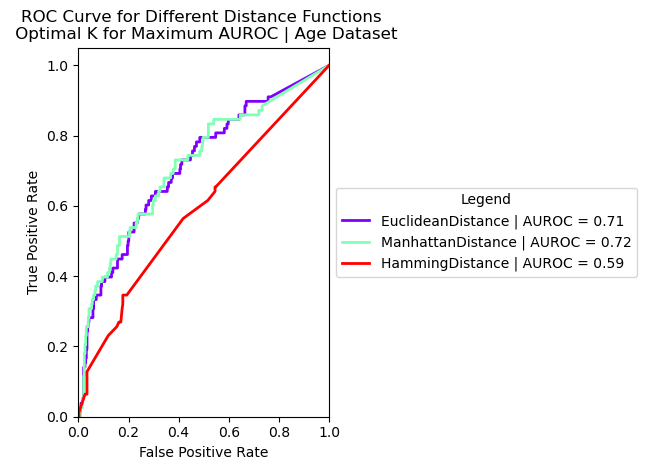

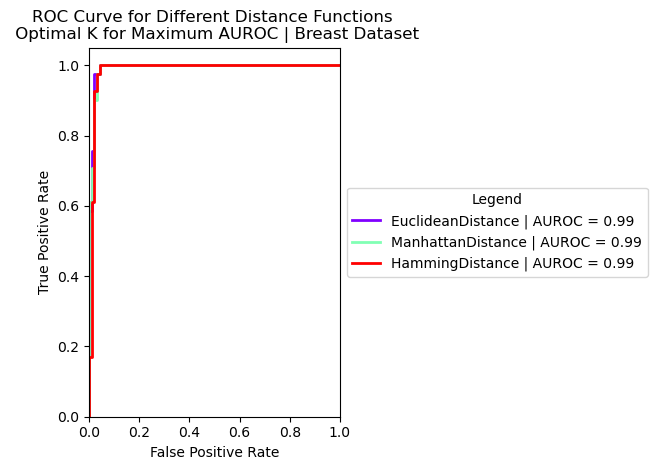

In [83]:
#4 Different cost functions
ageDataset, breastDataset = regenerate_datasets(False)

class ManhattanDistance:
    def __call__(self, input_vector: np.ndarray, feature_matrix: np.ndarray):
        return np.sum(np.abs(feature_matrix - input_vector), axis=1)

class CosineSimilarity:
    def __call__(self, input_vector: np.ndarray, feature_matrix: np.ndarray):
        input_vector = input_vector.flatten()  # Flatten to 1D if it's not already (for the dot product)
        input_norm = np.linalg.norm(input_vector)
        features_norm = np.linalg.norm(feature_matrix, axis=1)
        similarity = np.dot(feature_matrix, input_vector) / (features_norm * input_norm)
        return 1 - similarity

class HammingDistance:
    def __call__(self, input_vector: np.ndarray, feature_matrix: np.ndarray):
        return np.sum(feature_matrix != input_vector, axis=1)
    
def plot_knn_roc_for_select_functors(dataset, datasetName, vectorOfFunctors, krange = 15):
    class util:
        def __init__(self, fpr, tpr, auroc):
            self.fpr = fpr
            self.tpr = tpr
            self.auroc = auroc
    
    functorPlotStats = []
    for functor in vectorOfFunctors:
        best_util = None
        max_auroc = -1  # Initialize with a value lower than any possible AUROC
        for k in range(1, krange + 1):
            model = KNN(functor, k)
            fpr, tpr, auroc = create_roc_curve(model, dataset)
            current_util = util(fpr, tpr, auroc)

            # Check if the current util object has a higher AUROC -> for each functor we want maximum auroc (single k)
            if current_util.auroc > max_auroc:
                best_util = current_util
                max_auroc = current_util.auroc
        functorPlotStats.append(best_util)

    colors = cm.rainbow(np.linspace(0, 1, len(vectorOfFunctors)))
    plt.figure()
    for i, color in zip(range(len(vectorOfFunctors)), colors):
        plotstats = functorPlotStats[i]
        functorName = type(vectorOfFunctors[i]).__name__
        plt.plot(plotstats.fpr, plotstats.tpr, color=color, lw=2, label=f"{functorName} | AUROC = {plotstats.auroc:.2f}")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for Different Distance Functions \n Optimal K for Maximum AUROC | {datasetName}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Legend')
    plt.tight_layout()
    plt.show()

vectorOfDistanceFunctions = [EuclideanDistance(), ManhattanDistance(), HammingDistance()]
plot_knn_roc_for_select_functors(ageDataset, "Age Dataset", vectorOfDistanceFunctions)
plot_knn_roc_for_select_functors(breastDataset, "Breast Dataset", vectorOfDistanceFunctions)

In [84]:
#5 ROC done in 1



 Datasets cleaned.


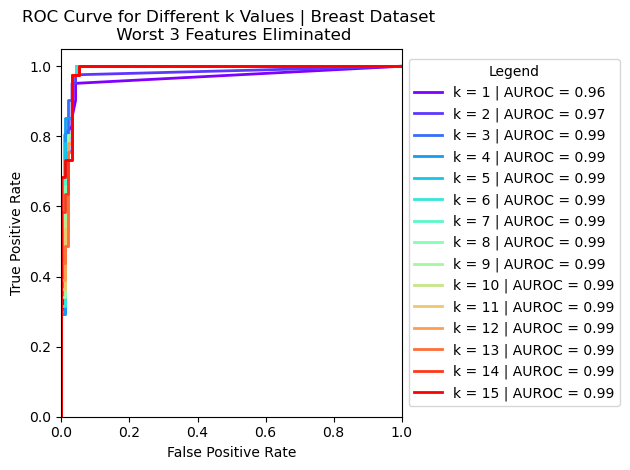

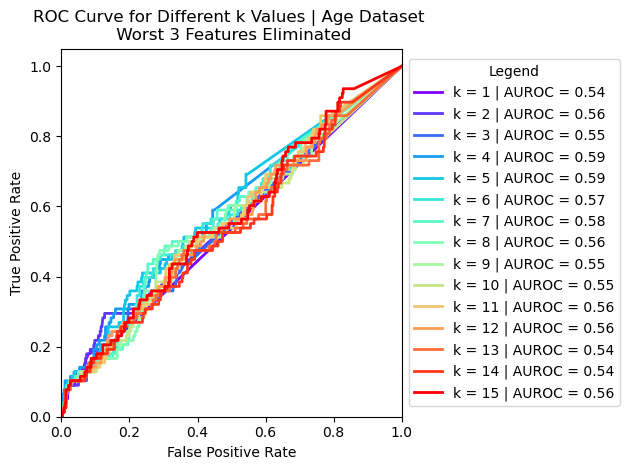

In [86]:
#6 Feature selection
# We can use Pearson correlation formula
ageDataset, breastDataset = regenerate_datasets()
def compute_correlation(X, y):
    correlations = []
    y_mean = np.mean(y)
    y_deviation = y - y_mean
    y_deviation_squared_sum = np.sum(y_deviation ** 2)
    
    for feature in X.T:  # X.T transposes the matrix to iterate over features
        x_mean = np.mean(feature)
        x_deviation = feature - x_mean
        covariance = np.sum(x_deviation * y_deviation)
        x_deviation_squared_sum = np.sum(x_deviation ** 2)
        
        # Calculate the Pearson correlation coefficient
        correlation_coefficient = covariance / np.sqrt(x_deviation_squared_sum * y_deviation_squared_sum)
        correlations.append(correlation_coefficient)
    
    return np.array(correlations)

# We can then use only the top 3 features for instance
def IsolateTopNFeatures(dataset:dataset, N=3):
    correlations = compute_correlation(dataset.features, dataset.targets)
    indices = correlations.argsort()[-N:][::-1]
    dataset.features = dataset.features[:, indices]

def RemoveWorstNFeatures(dataset : dataset, N=3):
    # Compute the correlation coefficients
    correlations = compute_correlation(dataset.features, dataset.targets)
    worst_indices = correlations.argsort()[:N]
    mask = np.ones(len(correlations), dtype=bool)
    mask[worst_indices] = False  # Set the worst feature indices to False
    dataset.features = dataset.features[:, mask] # Use mask to keep only the features that are true
    return dataset

RemoveWorstNFeatures(breastDataset, N=3)
RemoveWorstNFeatures(ageDataset, N=3)

plot_knn_roc_for_select_ks(breastDataset, datasetName="Breast Dataset \n Worst 3 Features Eliminated") #Works great for the breast dataset!
plot_knn_roc_for_select_ks(ageDataset, datasetName= "Age Dataset \n Worst 3 Features Eliminated") #Seems to make things worse for the age dataset...?
